In [1]:
from scipy.io import loadmat
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import normalize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pdb
import numpy as np
import copy
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

!nvidia-smi

cuda
Thu Aug 11 00:43:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
library = loadmat("/content/drive/MyDrive/ColabData/santabarbara_data_part_0.mat", squeeze_me = True)
bbl_flag = library["bbl"] == 1
wl = library["wl"]
label_names = library["gt_names"]
library.keys()

dict_keys(['__header__', '__version__', '__globals__', 'wl', 'bbl', 'A_gt_total', 'gt_names', 'I16s', 'endmembers16', 'endmembers16_r', 'endmembers4', 'endmembers4_r'])

In [5]:
images_16m = []
for image in library["I16s"]:
    images_16m.append(image)
print(len(images_16m))

images_16m_flatten = None
for image in images_16m:
    image = image[:, :, bbl_flag == 1]
    H, W, B = image.shape
    image = image.reshape((H*W, B))
    if images_16m_flatten is None: images_16m_flatten = image
    else: images_16m_flatten = np.vstack((images_16m_flatten, image))
print(images_16m_flatten.shape)

64
(8405, 164)


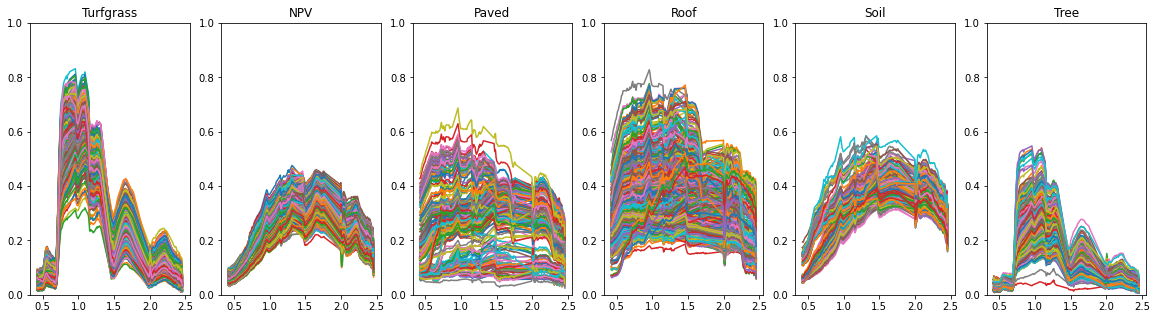

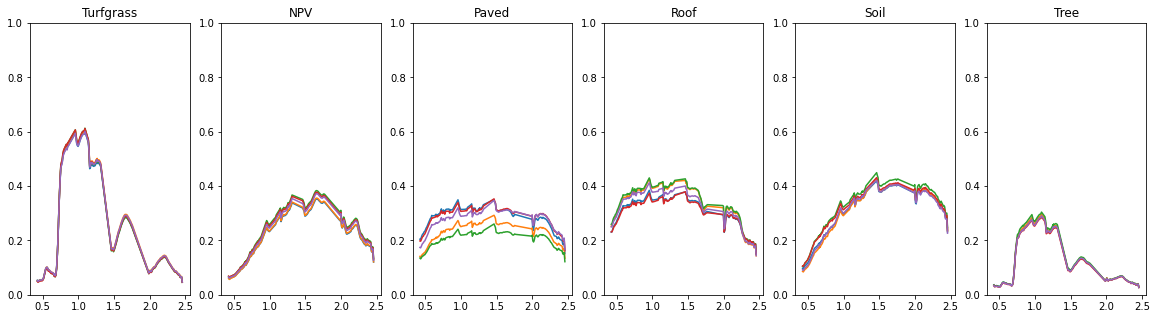

(3287, 164) (3287,)


In [6]:
e_16m_full, labels_full = None, None
n_class = len(library["endmembers16"])
plt.figure(figsize = [20, 5])

E_ranges, E_ctr = [], 0

for c in range(n_class):
    temp = library["endmembers16"][c]
    if e_16m_full is None: 
        e_16m_full = temp
        labels_full = np.ones(len(e_16m_full)) * c
    else: 
        e_16m_full = np.vstack((e_16m_full, temp))
        labels_full = np.concatenate((labels_full, np.ones(len(temp)) * c))
    E_ranges.append(np.arange(E_ctr, E_ctr + len(temp)))
    E_ctr += len(temp)
    plt.subplot(1, 6, c+1)
    plt.plot(wl[bbl_flag == 1], temp[:, bbl_flag == 1].T)
    plt.ylim([0, 1])
    plt.title(label_names[c])
plt.show()


#%% kmeans
from sklearn.cluster import KMeans
plt.figure(figsize = [20, 5])
for c in range(n_class):
    temp = library["endmembers16"][c]
    plt.subplot(1, 6, c+1)
    kmeans = KMeans(n_clusters = 5)
    kmeans.fit(temp)
    plt.plot(wl[bbl_flag == 1], kmeans.cluster_centers_[:, bbl_flag == 1].T)
    plt.ylim([0, 1])
    plt.title(label_names[c])
plt.show()

e_16m_full = e_16m_full[:, bbl_flag]
print(e_16m_full.shape, labels_full.shape)



X = torch.Tensor(images_16m_flatten).to(device)
X.requires_grad = False

E = torch.FloatTensor(e_16m_full)
E = E.to(device)
E.requires_grad = False

# print(E.shape, E.is_cuda, len(labels_full))
labels_full = torch.IntTensor(labels_full).to(device)

# print(E_ranges)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from __future__ import division

from torch.nn.modules.loss import _Loss

def BrayCurtisSimilarity(X, X_hat):
    return (torch.abs(X - X_hat).sum(dim = 1) / (X.sum(dim = 1) + X_hat.sum(dim = 1))).mean()


def SID(X, X_hat):
    p = (X / X.sum(dim = 1, keepdim = True)) + 1e-3
    q = (X_hat / X_hat.sum(dim = 1, keepdim = True)) + 1e-3
    return torch.sum(p * torch.log(p / q) + q * torch.log(q / p), dim = 1).mean()

def COS(X, X_hat):
    X_norm = X.norm(p = 2, dim = 1)
    X_hat_norm = X_hat.norm(p = 2, dim = 1)
    return 1 - (X * X_hat).sum(dim = 1) / (X_norm * X_hat_norm)

def SAD(X, X_hat):
    X_norm = X.norm(p = 2, dim = 1)
    X_hat_norm = X_hat.norm(p = 2, dim = 1)
    inner_product = (X * X_hat).sum(dim = 1)
    return torch.acos(inner_product / (X_norm * X_hat_norm)).mean()

def SIDSAM(X, X_hat):
    X_norm = X.norm(p = 2, dim = 1)
    X_hat_norm = X_hat.norm(p = 2, dim = 1)
    inner_product = (X * X_hat).sum(dim = 1)
    alpha = torch.acos(inner_product / (X_norm * X_hat_norm))

    p = (X / X.sum(dim = 1, keepdim = True))
    q = (X_hat / X_hat.sum(dim = 1, keepdim = True))
    sid =  torch.sum(p * torch.log(p / q + 1) + q * torch.log(q / p + 1), dim = 1)

    return (sid * torch.tan(alpha)).mean()

def JMSAM(X, X_hat):
    m_t, m_r = X.mean(dim = 1), X_hat.mean(dim = 1)
    sigma_t, sigma_r = X.var(dim = 1), X_hat.var(dim = 1)
    sigma_avg = (sigma_t + sigma_r) / 2
    B = 1/8 * (m_t - m_r)**2 / sigma_avg + 1/2*torch.log(torch.abs(sigma_avg) / torch.sqrt(sigma_t * sigma_r))
    X_norm, X_hat_norm = X.norm(p = 2, dim = 1), X_hat.norm(p = 2, dim = 1)
    inner_product = (X * X_hat).sum(dim = 1)
    alpha = torch.arccos(inner_product / (X_norm * X_hat_norm))
    return (2*(1-torch.exp(-B))*torch.tan(alpha)).mean()

def NS3(X, X_hat):
    _, B = X.shape
    l2_dist = torch.sqrt(((X - X_hat) ** 2).sum(dim = 1)/B)
    X_norm = X.norm(p = 2, dim = 1)
    X_hat_norm = X_hat.norm(p = 2, dim = 1)
    inner_product = (X * X_hat).sum(dim = 1)
    cos_alpha = inner_product / (X_norm * X_hat_norm)

    lower, upper = torch.min(X, dim = 1)[0], torch.max(X, dim = 1)[0]
    l2_dist = (l2_dist - lower) / (upper - lower)
    return torch.sqrt(l2_dist**2 + (1 - cos_alpha)**2).mean()

class Sparsemax(nn.Module):
    """Sparsemax function."""

    def __init__(self, dim=None):
        """Initialize sparsemax activation
        
        Args:
            dim (int, optional): The dimension over which to apply the sparsemax function.
        """
        super(Sparsemax, self).__init__()
        self.dim = -1 if dim is None else dim

    def forward(self, input):
        """Forward function.
        Args:
            input (torch.Tensor): Input tensor. First dimension should be the batch size
        Returns:
            torch.Tensor: [batch_size x number_of_logits] Output tensor
        """
        # Sparsemax currently only handles 2-dim tensors,
        # so we reshape to a convenient shape and reshape back after sparsemax
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)

        # Translate input by max for numerical stability
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)

        # Sort input in descending order.
        # (NOTE: Can be replaced with linear time selection method described here:
        # http://stanford.edu/~jduchi/projects/DuchiShSiCh08.html)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, step=1, device=device, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        # Determine sparsity of projection
        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]

        # Compute threshold function
        zs_sparse = is_gt * zs

        # Compute taus
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)

        # Sparsemax
        self.output = torch.max(torch.zeros_like(input), input - taus)

        # Reshape back to original shape
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)

        return output

    def backward(self, grad_output):
        """Backward function."""
        dim = 1

        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))

        return self.grad_input

class ParingLayer(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(n_features, n_features))

    def forward(self, H, V):
        return H @ self.weight @ V.T


def plot_all_endmembers(x, a, wl, E, labels, label_names):
    if isinstance(a, torch.Tensor):
        a = a.detach().cpu().numpy()
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    if isinstance(E, torch.Tensor):
        E = E.detach().cpu().numpy()
    indices = np.where(a != 0)[0]

    plt.subplot(1, 2, 1)
    plt.plot(wl, x.T, c = "b", label = "real")
    plt.plot(wl, (a @ E).T, c = "r", label = "reconstructed")
    plt.ylim([0, 1])
    plt.legend()

    plt.subplot(1, 2, 2)
    for idx in indices:
        plt.plot(wl, E[idx].T, alpha = a[idx] * 10, 
                 label = label_names[labels[idx]] + "#" + str(idx) + " " + str(np.round(a[idx], 2)))
    plt.legend()
    plt.ylim([0, 1])
    plt.show()
    
def plot_all_endmembers_merges(x, a, wl, E, labels, label_names):
    if isinstance(a, torch.Tensor):
        a = a.detach().cpu().numpy()
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    if isinstance(E, torch.Tensor):
        E = E.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    plt.subplot(1, 2, 1)
    plt.plot(wl, x.T, c = "b", label = "real")
    plt.plot(wl, (a @ E).T, c = "r", label = "reconstructed")
    plt.ylim([0, 1])
    plt.legend()

    plt.subplot(1, 2, 2)
    for c in range(6):
        flag = (a > 0) & (labels == c)
        if np.any(flag):
            weighted_mean = np.average(E[flag], weights=a[flag], axis = 0)
            plt.plot(wl, weighted_mean.T, label = label_names[c] + " " + str(np.round(a[flag].sum(), 2)))
            # print(label_names[c], np.round(a[flag].sum(), 2))
    plt.legend()
    plt.ylim([0, 1])
    plt.show()
    

# plot_all_endmembers(x[0], A[0], wl[bbl_flag == 1], E, labels_full, label_names)
# plot_all_endmembers_merges(x[0], A[0], wl[bbl_flag == 1], E, labels_full, label_names)

Individual
 Turfgrass, MAE: 0.035, R square: 0.817, RMSE: 0.058
       NPV, MAE: 0.059, R square: 0.908, RMSE: 0.089
     Paved, MAE: 0.073, R square: 0.923, RMSE: 0.096
      Roof, MAE: 0.056, R square: 0.802, RMSE: 0.071
      Soil, MAE: 0.047, R square: 0.954, RMSE: 0.067
      Tree, MAE: 0.074, R square: 0.924, RMSE: 0.093
average MAE: 0.057, average R square: 0.888, average RMSE: 0.079

Merged
        GV, MAE: 0.065, R square: 0.960, RMSE: 0.082
  Pervious, MAE: 0.060, R square: 0.956, RMSE: 0.082
Impervious, MAE: 0.071, R square: 0.956, RMSE: 0.082
average MAE: 0.065, average R square: 0.958, average RMSE: 0.082


 individual_maes: 0.057, merged_maes: 0.065
(132, 6)


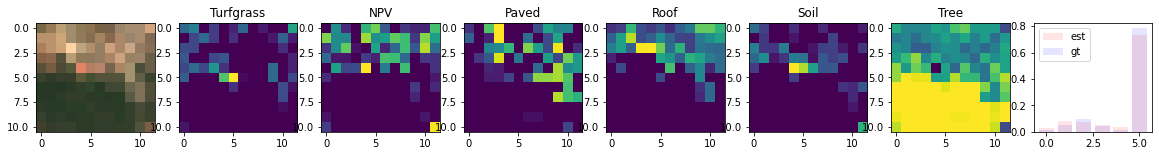

(144, 6)


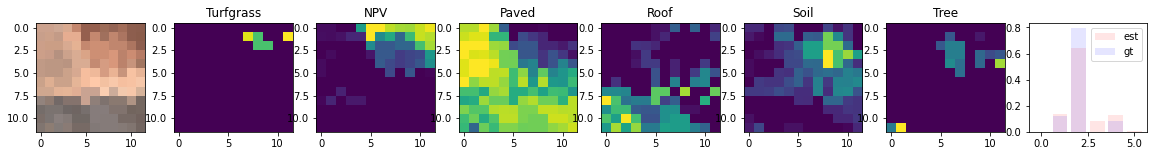

(121, 6)


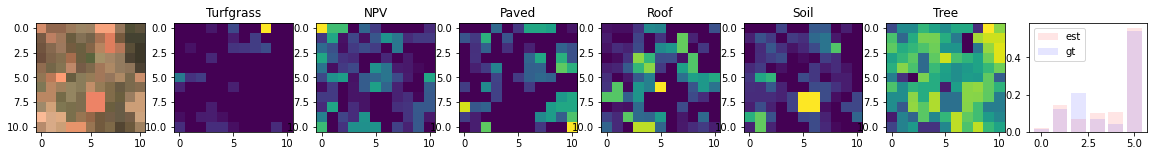

(132, 6)


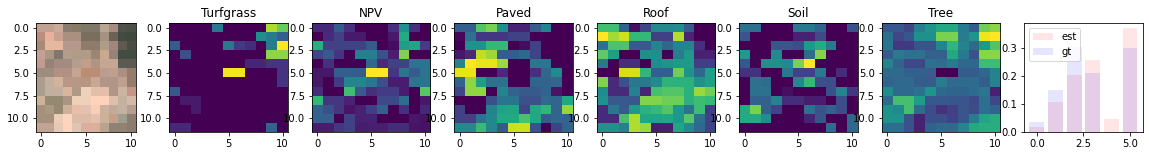

(132, 6)


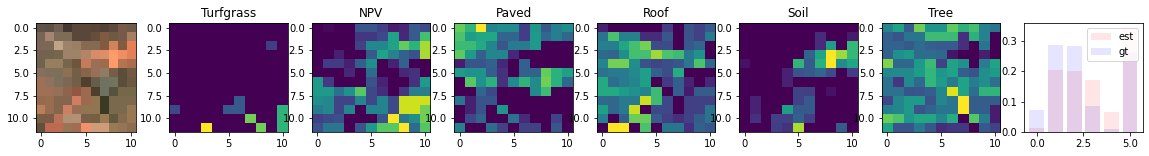

(132, 6)


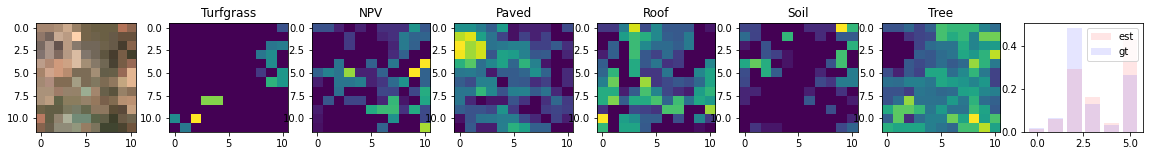

(132, 6)


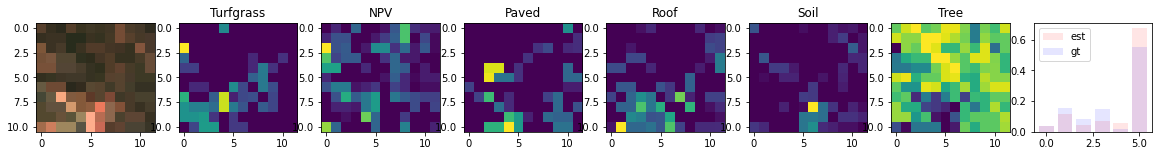

(121, 6)


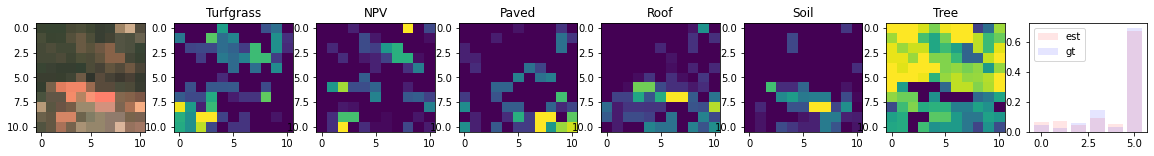

(121, 6)


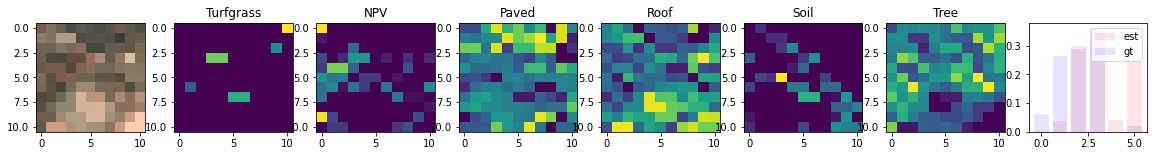

(132, 6)


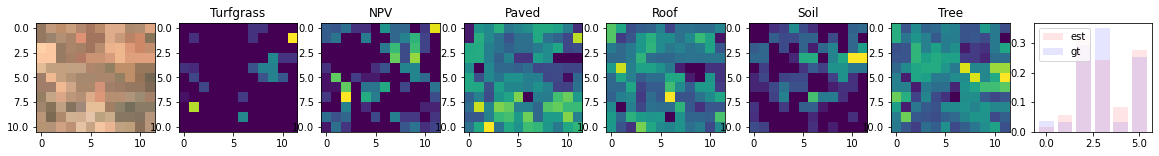

(132, 6)


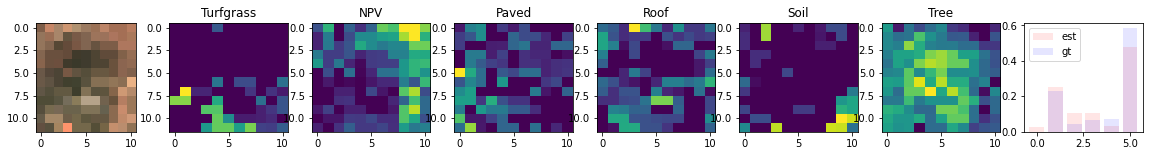

(121, 6)


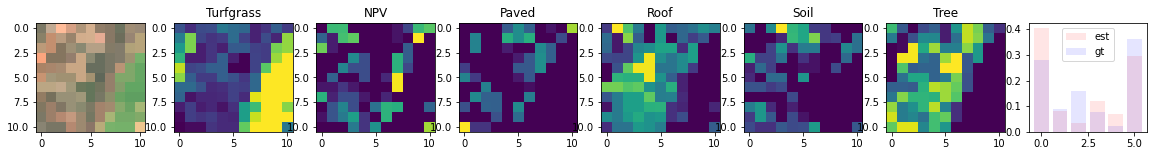

(121, 6)


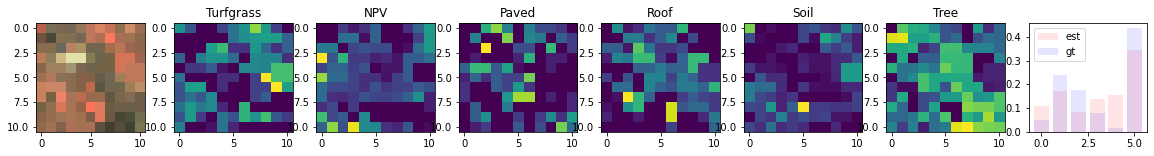

(121, 6)


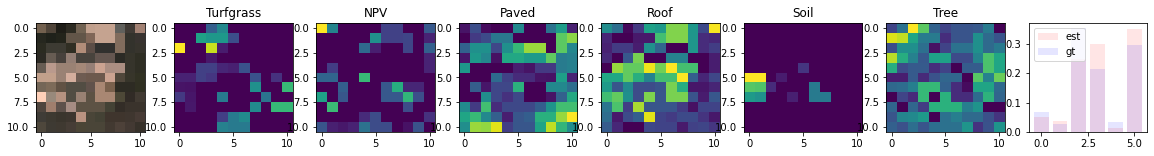

(132, 6)


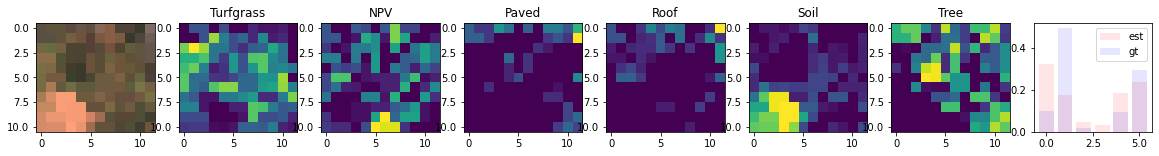

(132, 6)


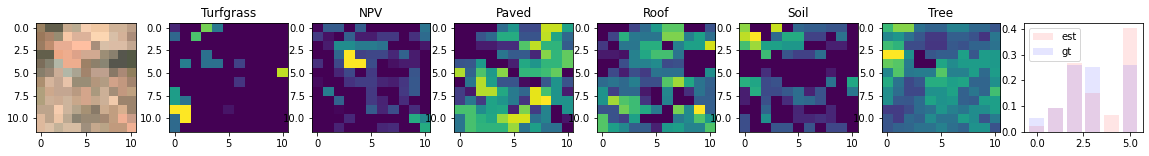

(144, 6)


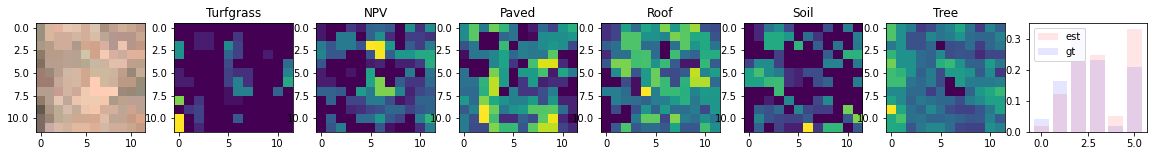

(132, 6)


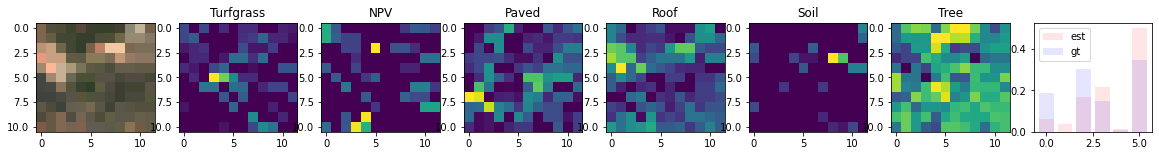

(132, 6)


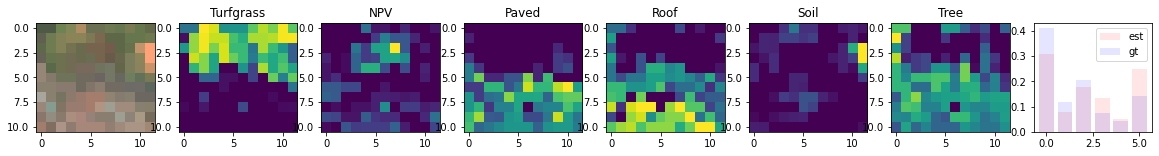

(132, 6)


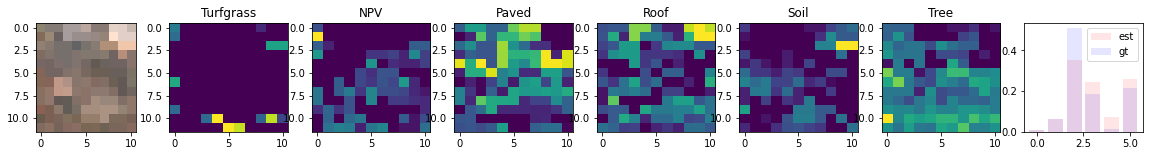

(132, 6)


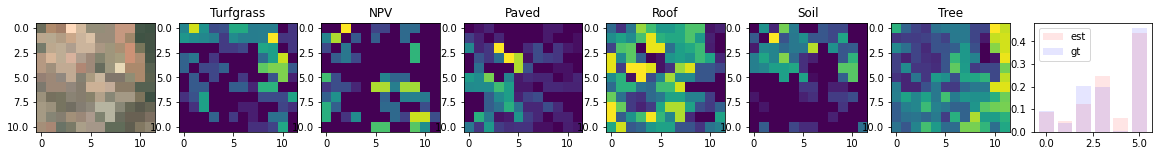

(121, 6)


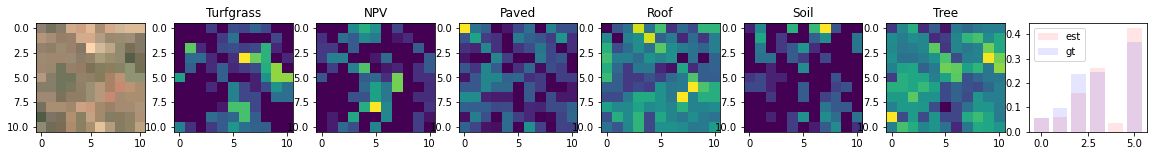

(132, 6)


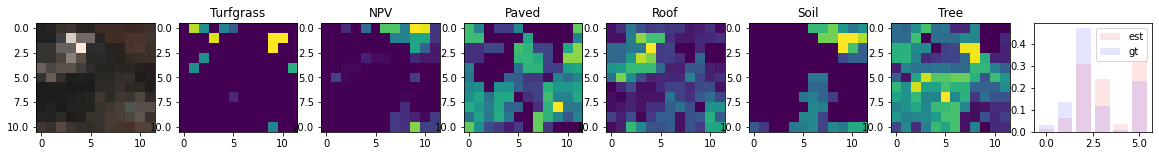

(132, 6)


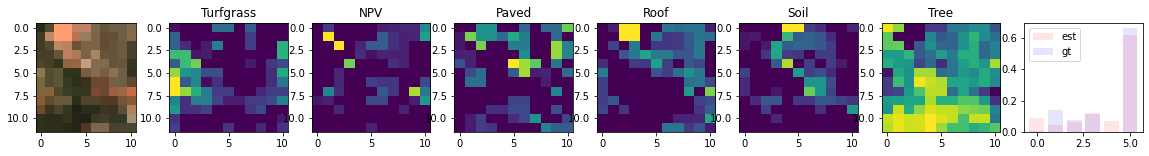

(132, 6)


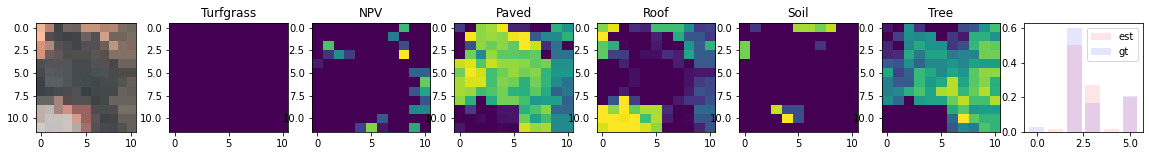

(132, 6)


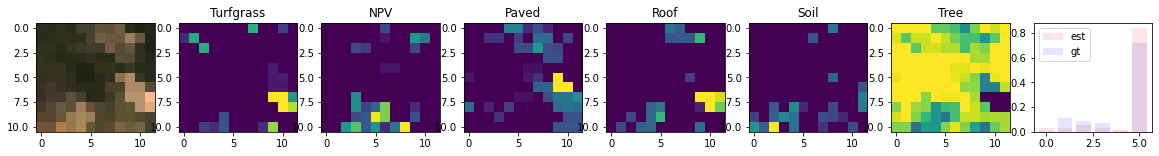

(132, 6)


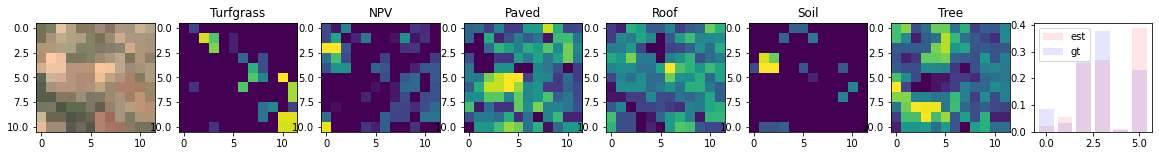

(132, 6)


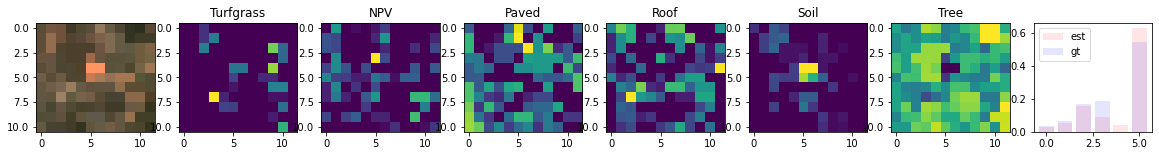

(144, 6)


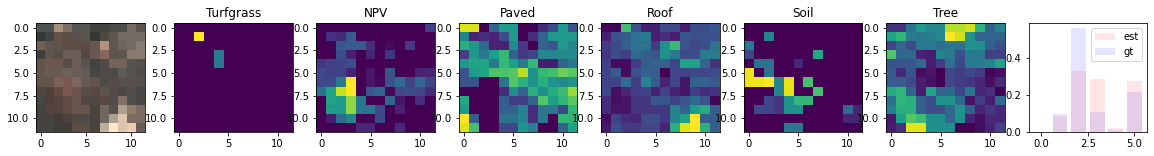

(132, 6)


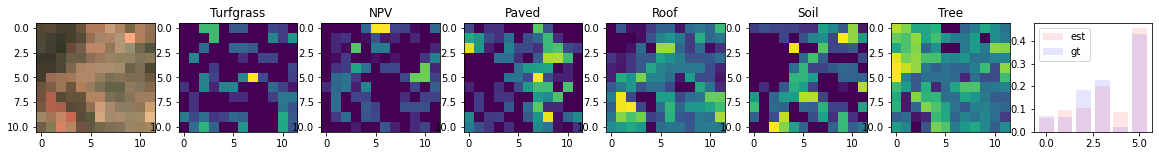

(132, 6)


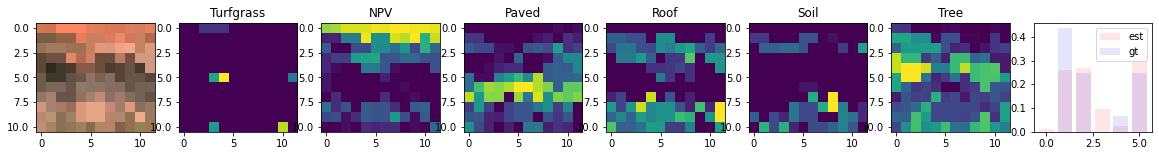

(121, 6)


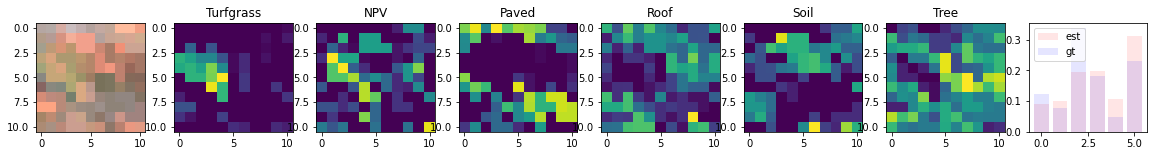

(144, 6)


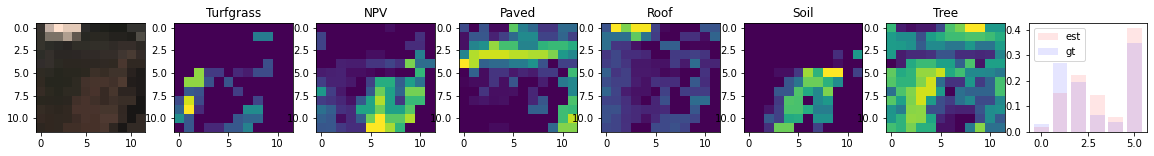

(144, 6)


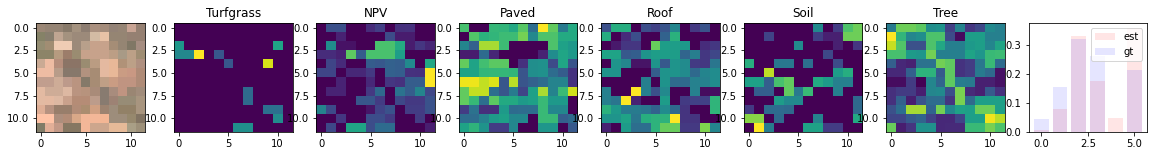

(121, 6)


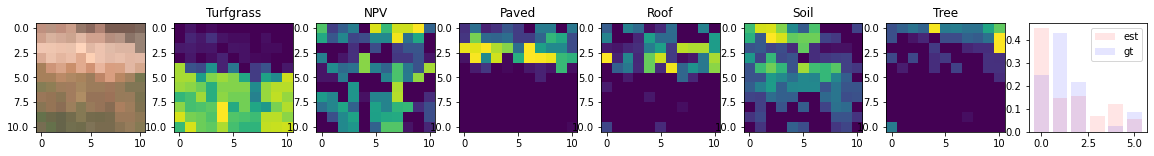

(121, 6)


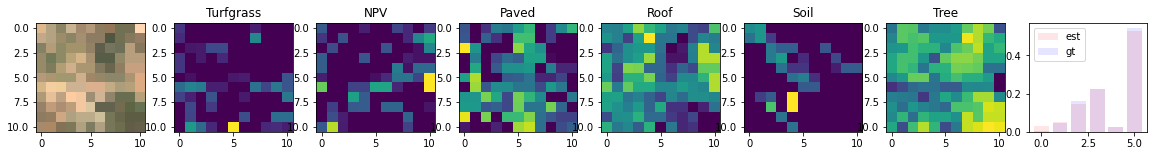

(132, 6)


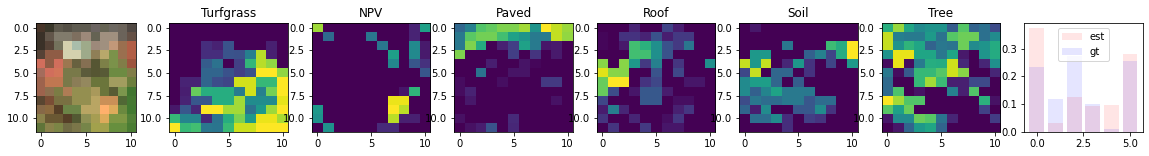

(132, 6)


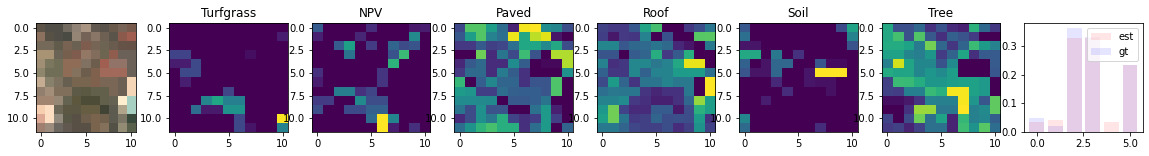

(121, 6)


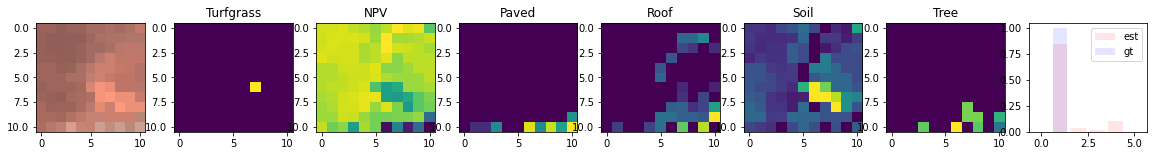

(132, 6)


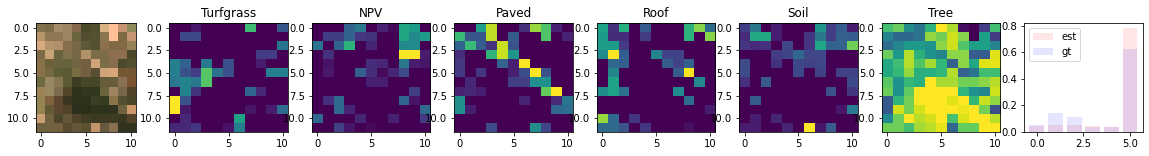

(144, 6)


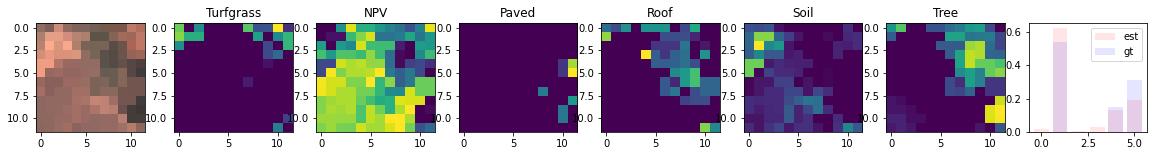

(121, 6)


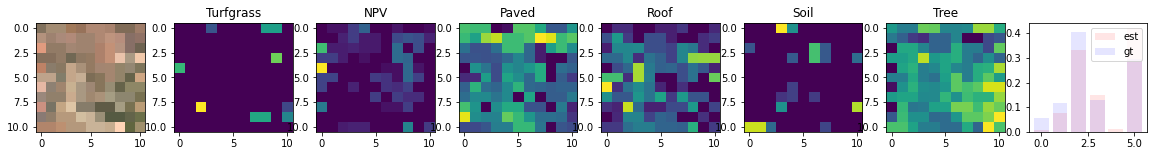

(121, 6)


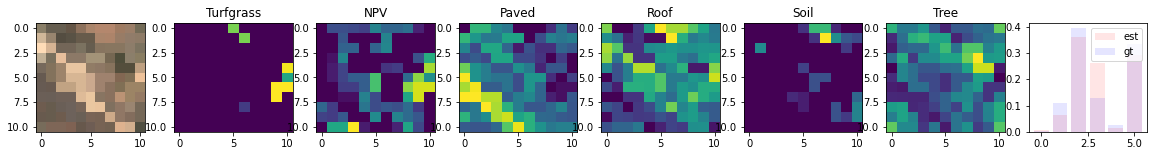

(121, 6)


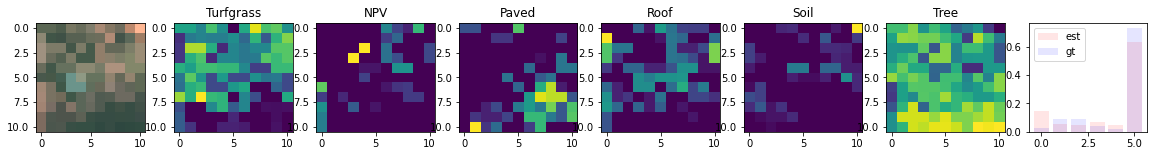

(144, 6)


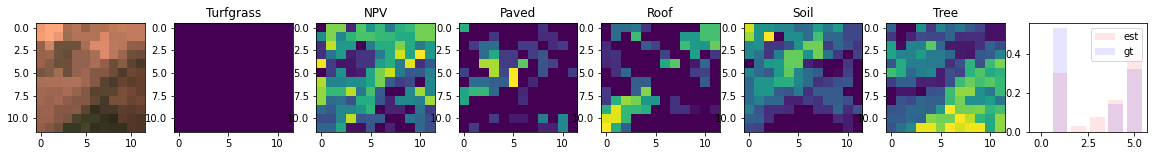

(132, 6)


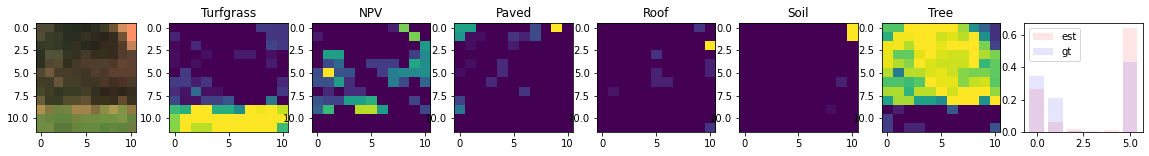

(144, 6)


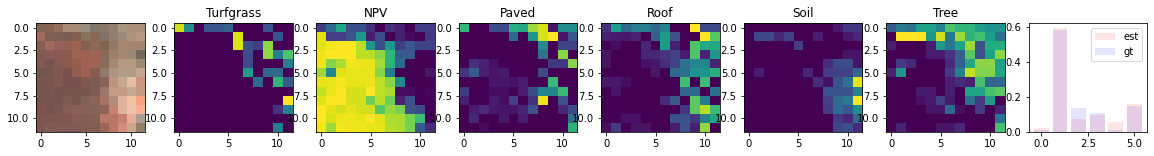

(121, 6)


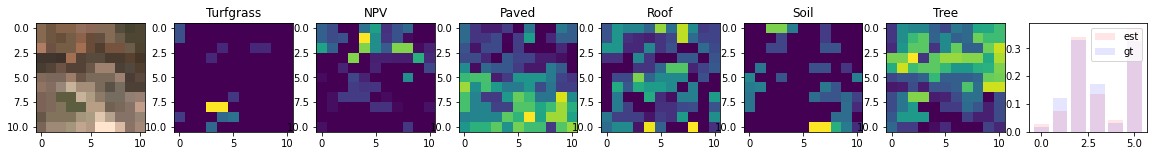

(144, 6)


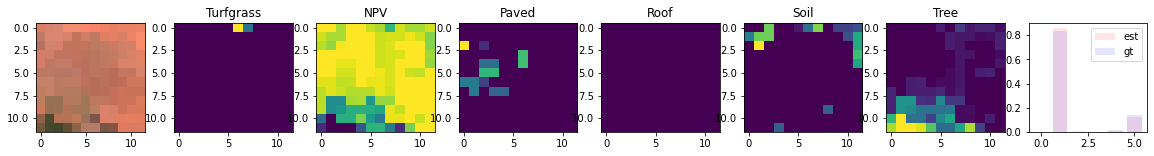

(132, 6)


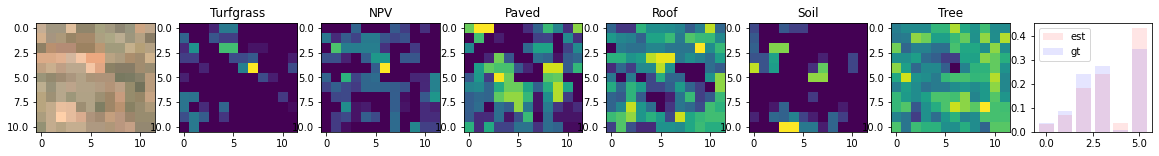

(144, 6)


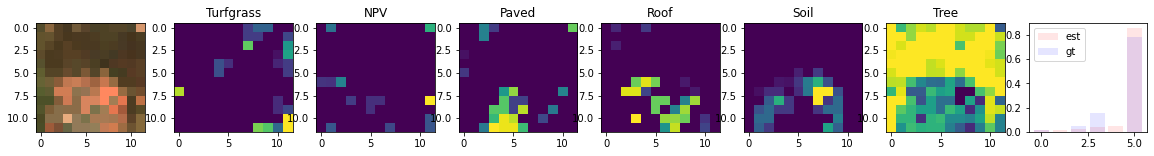

(132, 6)


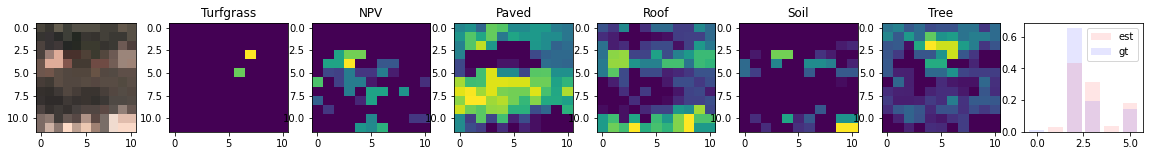

(132, 6)


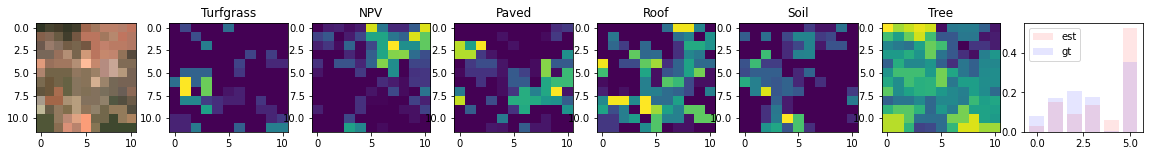

(132, 6)


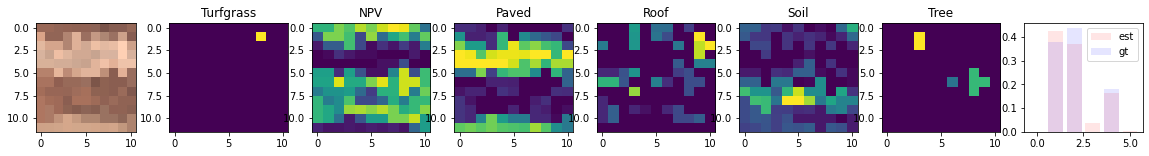

(132, 6)


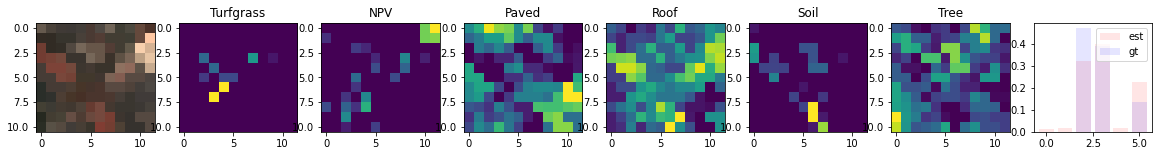

(132, 6)


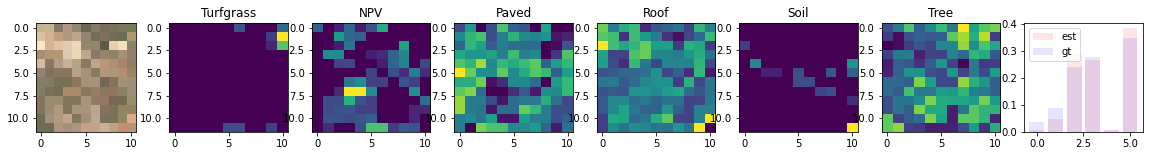

(121, 6)


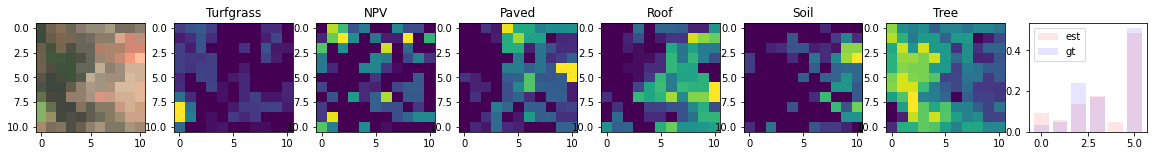

(132, 6)


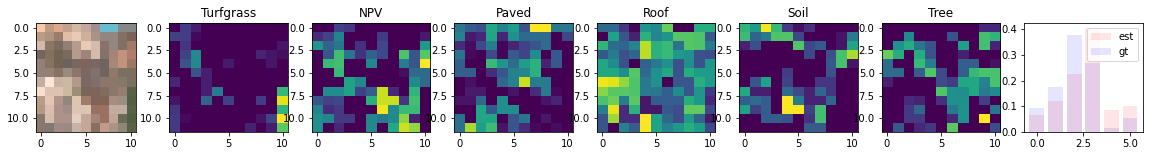

(121, 6)


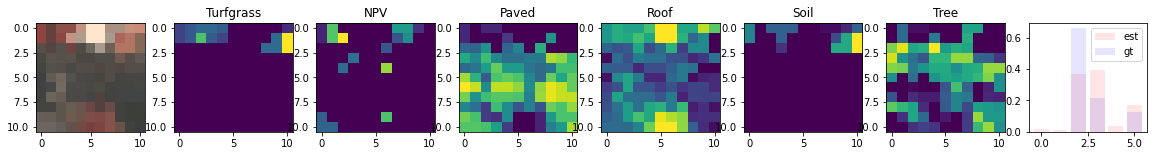

(144, 6)


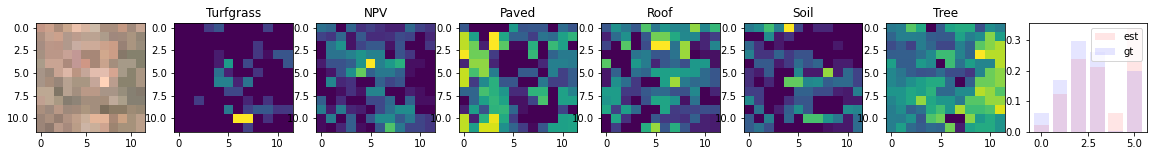

(132, 6)


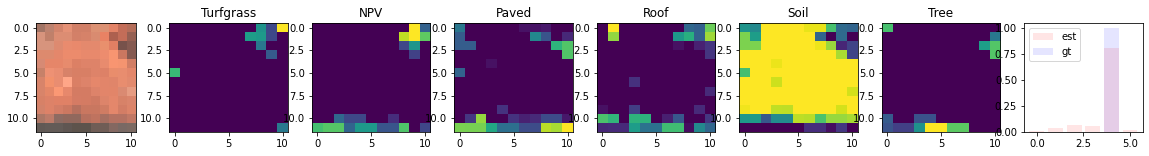

(144, 6)


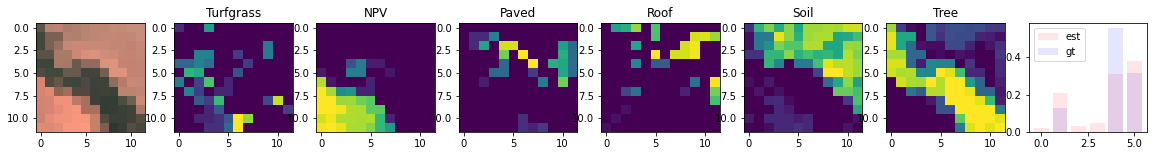

(132, 6)


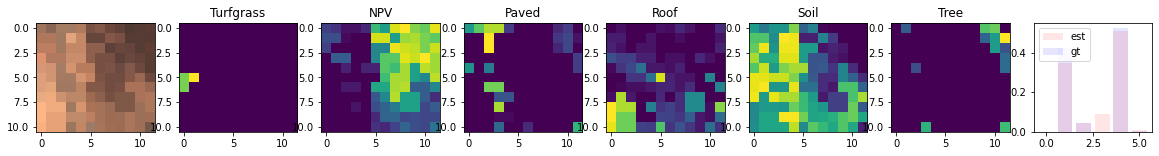

(132, 6)


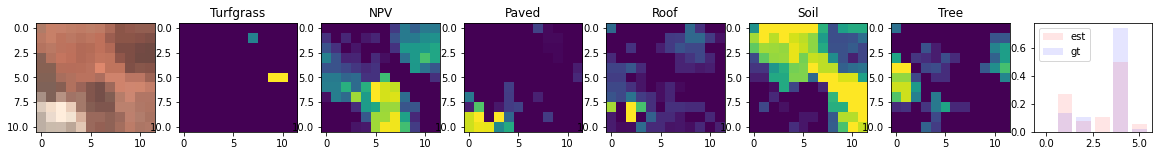

In [8]:
class MyMLP(nn.Module):

    def __init__(self, B, library_size):
        super(MyMLP, self).__init__()

        self.fc1 = nn.Linear(B, B//2)
        self.bn1 = nn.BatchNorm1d(B//2)
        self.fc2 = nn.Linear(B//2, B//4)
        self.bn2 = nn.BatchNorm1d(B//4)
        self.fc3 = nn.Linear(B//4, B//8)
        self.bn3 = nn.BatchNorm1d(B//8)

        self.spectra_encoder = [(self.fc1, self.bn1, nn.ReLU()), 
                                (self.fc2, self.bn2, nn.ReLU()),
                                (self.fc3, self.bn3, nn.Tanh())
                                ]

        self.embeddings = nn.Linear(B//8, library_size, bias = False)

        for fc in [self.fc1, self.fc2, self.fc3, self.embeddings]:
            torch.nn.init.xavier_normal_(fc.weight)
        
    def encoding_spectra(self, X):
        H = X
        for fc, bn, activation in self.spectra_encoder:
            H = fc(H)
            if bn is not None: H = bn(H)
            if activation is not None: H = activation(H)
        return H

    def forward(self, X):
        H = self.encoding_spectra(X)
        inner_product = self.embeddings(H)
        A = Sparsemax(dim = 1)(inner_product)
        # A = nn.Softmax(dim = 1)(inner_product)
        return A


from collections import Counter
ctr = Counter(labels_full.detach().cpu().numpy())
foo = [ctr[key] for key in range(6)]

endmember_ranges, acc = [], 0
for i in range(6):
    endmember_ranges.append(np.arange(acc, acc + foo[i]))
    acc += foo[i]

def merge_full_to_6(A, endmember_ranges):
    A_merged = np.zeros((len(A), 6))
    for i in range(len(A)):
        row = A[i]
        for j in range(len(endmember_ranges)):
            A_merged[i, j] = np.sum(row[endmember_ranges[j]])
    return A_merged

def merge_6_to_3(A):
    A_merged = np.zeros((len(A), 3))
    gv_indices = np.array([0, 5])
    pervious_indices = np.array([1, 4])
    impervious_indices = np.array([2, 3])
    A_merged[:, 0] = np.sum(A[:, gv_indices], axis = 1)
    A_merged[:, 1] = np.sum(A[:, pervious_indices], axis = 1)
    A_merged[:, 2] = np.sum(A[:, impervious_indices], axis = 1)
    return A_merged


A_gt = library["A_gt_total"]
A_gt_merged = merge_6_to_3(A_gt)

import time
cleanup, verbose = True, False
cleanup_threshold = 1e-2 
lr, individual_maes, merged_maes = 1e-3, [], []
C = 6


A = np.zeros((len(X), len(E)))
pixel_ranges, pixel_offset = [], 0

for k, image in enumerate(images_16m):
    image = image[:, :, bbl_flag == 1]
    H, W, B = image.shape
    x = torch.Tensor(image.reshape((H*W, B))).to(device)
    pixel_ranges.append(np.arange(pixel_offset, pixel_offset + int(H*W)))
    pixel_offset += int(H*W)
    As = []

    for seed in range(10):
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        model = MyMLP(164, len(E)).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        start_time = time.time()

        for epoch in range(500):
            model.train()
            a = model(x)
            if epoch >= 200 and cleanup:
                mask = torch.ones(a.shape).to(device) 
                mask[a <= cleanup_threshold] = 0
                a *= mask
                a /= a.sum(dim = 1, keepdim = True)
            x_hat = a @ E
            optimizer.zero_grad()
            total_loss = nn.L1Loss(reduction = "mean")(x_hat, x) 
            total_loss.backward()
            optimizer.step()

        As.append(a)


    A_best = np.zeros((H*W, len(E)))
    for pixel_idx in range(int(H*W)):
        best_n_comp, best_mse, best_a = float("inf"), float("inf"), None
        for a in As:
            foo = merge_full_to_6(a[pixel_idx].detach().cpu().numpy().reshape((1, -1)), endmember_ranges)
            n_comp, mse = np.count_nonzero(foo), ((x[pixel_idx] - (a[pixel_idx] @ E)) ** 2).mean().item()
            if n_comp <= best_n_comp and mse <= best_mse:
                best_n_comp = n_comp; best_mse = mse; best_a = a[pixel_idx].detach().cpu().numpy()
        A_best[pixel_idx] = best_a

    A[pixel_ranges[k]] = A_best


A_est_pixel = merge_full_to_6(A, endmember_ranges)
A_est_merged_pixel = merge_6_to_3(A_est_pixel)
A_est = np.zeros(A_gt.shape)
A_est_merged = np.zeros(A_gt_merged.shape)

for k, pixel_range in enumerate(pixel_ranges):
    A_est[k] = A_est_pixel[pixel_range].mean(axis = 0)
    A_est_merged[k] = A_est_merged_pixel[pixel_range].mean(axis = 0)

print("Individual")
MAEs, RMSEs, Rs = [], [], []
for c in range(C):
    mae = np.abs(A_est[:, c] - A_gt[:, c]).mean()
    rmse = np.sqrt(((A_est[:, c] - A_gt[:, c]) ** 2).mean())
    r = pearsonr(A_est[:, c], A_gt[:, c])[0]
    print("%10s, MAE: %.3f, R square: %.3f, RMSE: %.3f" % (label_names[c], mae, r, rmse))
    MAEs.append(mae); RMSEs.append(rmse); Rs.append(r)
print("average MAE: %.3f, average R square: %.3f, average RMSE: %.3f" %(np.mean(MAEs), np.mean(Rs), np.mean(RMSEs)))
individual_maes.append(np.mean(MAEs))

print("\nMerged")
merged_names = ["GV", "Pervious", "Impervious"]
MAEs, RMSEs, Rs = [], [], []
for c in range(3):
    mae = np.abs(A_est_merged[:, c] - A_gt_merged[:, c]).mean()
    rmse = np.sqrt(((A_est_merged[:, c] - A_gt_merged[:, c]) ** 2).mean())
    r = pearsonr(A_est_merged[:, c], A_gt_merged[:, c])[0]
    print("%10s, MAE: %.3f, R square: %.3f, RMSE: %.3f" % (merged_names[c], mae, r, rmse))
    MAEs.append(mae); RMSEs.append(rmse); Rs.append(r)
print("average MAE: %.3f, average R square: %.3f, average RMSE: %.3f" %(np.mean(MAEs), np.mean(Rs), np.mean(RMSEs)))
merged_maes.append(np.mean(MAEs))


print("\n\n individual_maes: %.3f, merged_maes: %.3f" %(np.mean(individual_maes), np.mean(merged_maes)))

for k, image in enumerate(images_16m):
    H, W, _ = image.shape
    foo = merge_full_to_6(A[pixel_ranges[k], :], endmember_ranges)
    print(foo.shape)
    fig, axs = plt.subplots(nrows=1, ncols=8, figsize = [20, 2])
    axs[0].imshow(image[:, :, np.array([35, 18, 11])] / image[:, :, np.array([35, 18, 11])].max())
    for c in range(C):
        axs[c+1].imshow(foo[:, c].reshape((H, W)), aspect="auto")
        axs[c+1].set_title(label_names[c])
        # plt.colorbar()
    axs[7].bar(x = np.arange(6), height = foo.mean(axis = 0), color = "r", alpha = 0.1, label = "est")
    axs[7].bar(x = np.arange(6), height = library["A_gt_total"][k], color = "b", alpha = 0.1, label = "gt")
    axs[7].legend()
    plt.show()